Mouse runs several laps on a track. Calculate mean neuron activity at certain binned positions and plot correlation matrices of the signals.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import sys
from scipy.signal import savgol_filter

In [44]:
def load_var(path):
    int_df = pd.read_csv(os.path.join(path, 'int.csv'))
    signal_df = pd.read_csv(os.path.join(path, 'signal.csv'))
    action_df = pd.read_csv(os.path.join(path, 'action.csv'))
    pos = action_df['pos']
    v = action_df['v']
    licking = action_df['licking']
    signal = signal_df['S'].values.reshape(int_df['num_neurons'].values[0], int_df['num_times'].values[0])
    
    return signal, pos, v, licking

def get_signals(paths, sd=True, only_velocity=False):
    
    #load signals
    signal, pos, v, licking = load_var(path)
    
    #get rid of empty neurons
    std_dev = np.std(signal, axis=1, keepdims=True)
    invalid_neurons = [i for i, v in enumerate(std_dev) if v == 0]
    valid_neurons_mask = np.logical_not(np.isin(np.arange(signal.shape[0]), invalid_neurons))
    signal = signal[valid_neurons_mask]

    #normalize
    if sd:
        std_dev = std_dev[valid_neurons_mask]
        mean = np.mean(signal, axis=1, keepdims=True)
        signal = (signal - mean) / std_dev
    
    #use only times when mouse moving
    if only_velocity:
        running_indices = np.where(np.array(v) > 2)[0]
        position = np.array(pos)[running_indices]
        signal = np.squeeze(signal[:, running_indices])
        licking = np.array(licking)[running_indices]

    return signal, pos, licking


def remove_redundant_indices(indices):
    cleaned_indices = []
    
    prev_index = None
    for index in indices:
        if prev_index is None or index != prev_index + 1:
            cleaned_indices.append(index)
        prev_index = index

    return np.array(cleaned_indices)

#find indexes of array values
def find_values_and_indexes(signal_array, target_values):
    mask = np.isin(signal_array.astype(int), target_values)
    matching_indexes = remove_redundant_indices(np.where(mask)[0])
    matching_values = signal_array[mask]

    return matching_indexes, matching_values

#find new laps
def find_new_laps(pos):
    new_laps = []
    for i in range(1, len(pos) - 1):
        if pos[i - 1] > pos[i]+100:
            new_laps.append(i)

    return new_laps

def mean_signal_from_bins(neuron_signal_pieces, binned_pieces):
    mean_signals = []
    for S, p in zip(neuron_signal_pieces, binned_pieces):
        mean_signal = []
        for i in range(1, len(p)):
            mean_signal.append(np.mean(S[:, p[i - 1]:p[i]], axis=1))
        mean_signals.append(mean_signal)
    return np.array(mean_signals)


def get_mean_signals(S, pos, bin_number):
    #infer velocity from position (velocity signal noisy for some datasets)
    derivative = np.gradient(pos)
    threshold = 0.1
    non_zero_indices = np.where(derivative >= threshold)
    filtered_pos = pos[non_zero_indices[0]]
    
    #find new laps
    laps = find_new_laps(list(filtered_pos))
    
    #split position into laps
    signal_pieces = np.split(filtered_pos, laps)[1:-1]
    
    #split neuron signals based on the laps
    neuron_signal_pieces = np.split(S, laps, axis=1)[1:-1]
    
    #smooth position to make continuous
    smoothed_pieces = [savgol_filter(piece, window_length=60, polyorder=3) for piece in signal_pieces]
    binned_pieces = []
    
    #bin by position
    for piece in smoothed_pieces:
        target_values = np.round(np.linspace(min(piece), max(piece), bin_number + 2)[1:-1]).astype(int)
        matching_indexes, _ = find_values_and_indexes(piece, target_values)
        binned_pieces.append(matching_indexes)
    
    #get_mean_signals
    mean_signals = mean_signal_from_bins(neuron_signal_pieces, binned_pieces)

    return mean_signals


#to calculate correlation matrix, neurons1 == neurons2 or pca1 == pca2
def align_and_calculate_correlation(signal1, signal2, pca_comps):
    pca_signal1 = PCA(n_components=max(pca_comps)+1).fit_transform(signal1).T[pca_comps,:]
    pca_signal2 = PCA(n_components=max(pca_comps)+1).fit_transform(signal2).T[pca_comps,:]
    print(pca_signal1.shape, pca_signal2.shape)
    
    matrix = np.corrcoef(pca_signal1.T, pca_signal2.T)
    return matrix

#plotting functions
def plot_correlation_matrix(correlation_matrix):

    plt.imshow(correlation_matrix, cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title("Correlation Matrix")
    plt.show()
    
def plot_stacked_signals(signals):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(signals)):
        z = np.full_like(signals[i], i)  # Create a z-axis for the current signal
        ax.plot(z, np.arange(len(signals[i])),signals[i],  label=f'Signal {i+1}')

    # Set labels and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_zlabel('Signal Number')
    ax.set_title('Stacked 3D Signal Plots')
    ax.view_init(elev=20, azim=30)  # Set the elevation and azimuthal angles
    # Show the plot
    plt.show()
    
def plot_heatmap(signal, title='', xlabel='', ylabel='', tick_low=0, tick_high=1.2):

    ax = sns.heatmap(signal.T, cmap='viridis', cbar_kws={'label': 'Neuron Activity'})
    ax.set_yticks([])

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([tick_low, tick_high])
    cbar.set_ticklabels(['Low', 'High'])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
    
def plot_correlation_matrices(matrix):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot autocorrelation matrix
    rows, cols = matrix.shape
    autocorrelation_matrix = matrix[:rows//2,:cols//2]
    axes[0].imshow(autocorrelation_matrix, cmap='viridis', interpolation='none')
    axes[0].set_title("Autocorrelation Matrix")
    axes[0].grid(False)

    # Plot cross-correlation matrix
    crosscorrelation_matrix = matrix[:rows//2, cols//2:]
    axes[1].imshow(crosscorrelation_matrix, cmap='viridis', interpolation='none')
    axes[1].set_title("Cross-correlation Matrix")
    axes[1].grid(False)

    plt.show()

In [45]:
pathR1 = '/home/martin/Data/processed_magdeburg_data/Reward/1'
pathR2 = '/home/martin/Data/processed_magdeburg_data/Reward/2'
pathR3 = '/home/martin/Data/processed_magdeburg_data/Reward/3'
pathB1 = '/home/martin/Data/processed_magdeburg_data/Brake/1'
pathB2 = '/home/martin/Data/processed_magdeburg_data/Brake/2'
pathB3 = '/home/martin/Data/processed_magdeburg_data/Brake/3'
pathP1 = '/home/martin/Data/processed_magdeburg_data/Puff/1'
pathP2 = '/home/martin/Data/processed_magdeburg_data/Puff/2'
pathP3 = '/home/martin/Data/processed_magdeburg_data/Puff/3'
paths = [pathR1,pathR2,pathR3,pathB1, pathB2, pathB3, pathP1,pathP2,pathP3]

In [61]:
signals = []
for path in paths[3:5]:
    S, pos, _ = get_signals([path], only_velocity=False)
    S = get_mean_signals(S,pos,24)
    signal = np.mean(np.array(S)[:,:,:],axis=0)
    signals.append(signal)

/home/martin/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/lib/shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))
/home/martin/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/lib/shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


(10, 23) (10, 23)


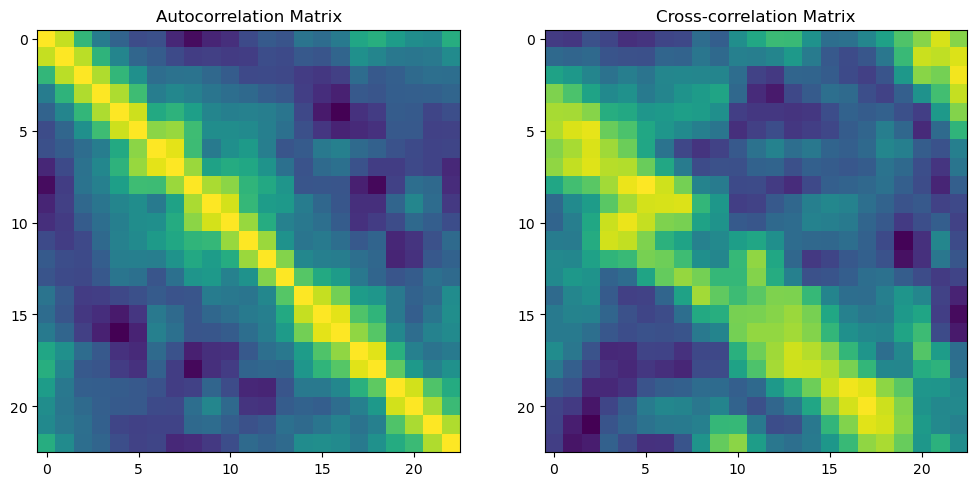

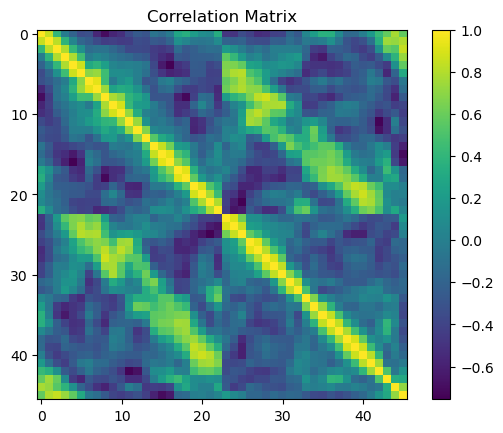

(46, 46)


In [62]:
matrix = align_and_calculate_correlation(signals[0], signals[1], [0,1,2,3,4,5,6,7,8,9])
plot_correlation_matrices(matrix)
plot_correlation_matrix(matrix)

print(matrix.shape)